# Read in the data

In [56]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [57]:
data['class_size']["GRADE "].value_counts()

12-Sep     10644
MS Core     4762
0K-09       1384
0K          1237
1           1185
2           1167
3           1143
4           1140
5           1086
6            846
7            778
8            735
9             20
Name: GRADE , dtype: int64

In [58]:
data['class_size']['GRADE '] = data['class_size']['GRADE '].replace('12-Sep','09-12')

In [59]:
data['class_size']["GRADE "].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
1           1185
2           1167
3           1143
4           1140
5           1086
6            846
7            778
8            735
9             20
Name: GRADE , dtype: int64

# Read in the surveys

In [60]:
all_survey = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [61]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [62]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [63]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [64]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [65]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [66]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [67]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


# Plotting survey correlations

In [68]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

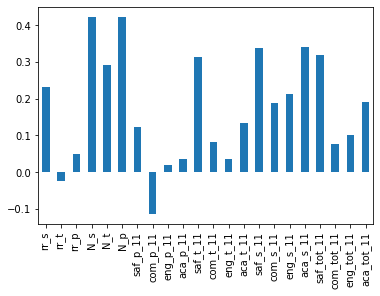

In [69]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

The highest correlatinos are seen between: 
- N_s: Number of student respondents, 
- N_t: Number of teacher respondents, 
- N_p: Number of parent respondents, 
- saf_s_11: Safety and Respect score based on student responses, 
- aca_s_11: Academic expectations score based on parent responses, 
- saf_tot_11: Safety and Respect total score,  
- saf_t_11: Safety and Respect score based on teacher responses.

The number ones are interesting and there are a few ways to think about these. It could be that responsiveness to the survey implies responsibilty, which could be a factor in SAT performance. It could also be that those with a higher score were more willing to share that score. Lastly it could be that a higher number of respondents means a larger school, and larger schools could earn higher SAT scores. 

There are two parts to Safety and Respect scores. The first part, Safety, likely means that students who feel comfortable at school are able to better focus on academic development. Respect could either be interpreted as student's with a better respect for authority which could cause higher scores, or it could imply that the teachers are better and command a higher degree of respect.

Lastly, Academic Expectations from parents seems like a pretty obvious one.

# Investigating Safety Scores

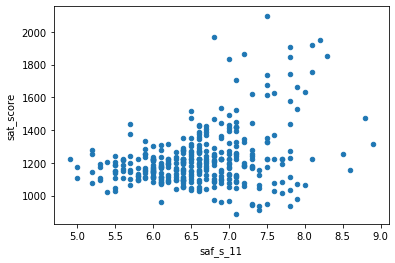

In [70]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

There does seem to be a slight positive trend until a school reaches a saf_s_11 score of ~6.5, after which the positive trend seems to be stronger. No school at 6.5 or below averages an SAT score higher than 1600.

In [71]:
try:
    from inspect import cleandoc as dedent
except ImportError:
    # Deprecated as of version 3.1. Not quite the same
    # as textwrap.dedent.
    from matplotlib.cbook import dedent

C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


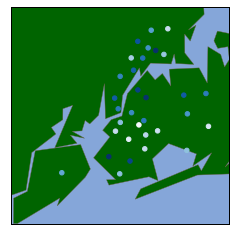

In [81]:
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = r'C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='darkgreen',lake_color='#85A6D9')

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='Blues')
plt.show()

Brooklyn seems to have the lowest, while Mahattan and Queens seem to have higher safety scores.

In [84]:
combined['sat_score'].plot(type='bar','white_per','asian_per','black_per','hispanic_per')

SyntaxError: positional argument follows keyword argument (<ipython-input-84-af1fcdef5e46>, line 1)